Null Values in each column:
 LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Total Null Values:  7829

Dropping features with more than 500 null values: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


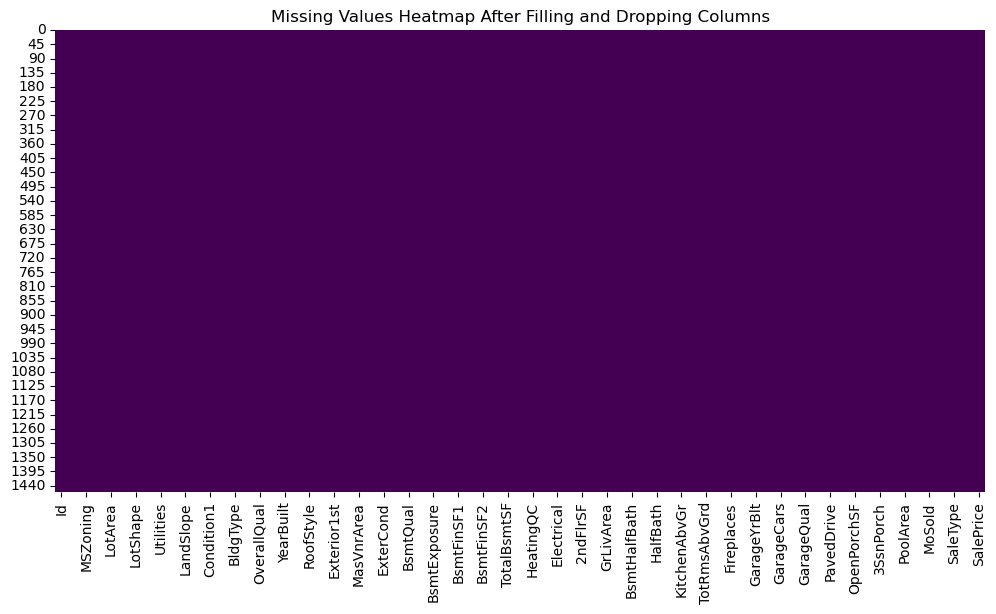

Data after one-hot encoding:
    Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLI  SaleType_ConLw  \
0          2003       196.0         706  ...           False           False   
1          1976         0.0         978  ...           False           False   
2          2002       162.0         486  ...           False           False   
3          1970         0.0         216  ...           False           False   
4          2000       350.0         655  ...           False           False   

   SaleT

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/sample_submission.csv'

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# Step 1: Import the train.csv
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Step 2: Check for Null Values and analyze it
null_values = train.isnull().sum()
print("Null Values in each column:\n", null_values[null_values > 0])
print("\nTotal Null Values: ", null_values.sum())

# Separate numeric and categorical columns
numeric_cols = train.select_dtypes(include=['number']).columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Fill missing values for numeric columns with the median
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())

# Fill missing values for categorical columns with the mode (most frequent value)
for col in categorical_cols:
    mode_val = train[col].mode()[0]  # Get the most frequent value
    train[col].fillna(mode_val, inplace=True)

# Drop features with more than 500 null values (this should now be zero since missing values are filled)
features_to_drop = null_values[null_values > 500].index
print(f"\nDropping features with more than 500 null values: {features_to_drop.tolist()}")
train.drop(columns=features_to_drop, inplace=True)

# Analyze the missing data after filling and dropping features (optional visualization)
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap After Filling and Dropping Columns')
plt.show()

# Step 3: One-hot encoding for each string-based feature
# Identify categorical variables
categorical_cols = train.select_dtypes(include=['object']).columns

# Apply one-hot encoding to categorical variables
train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

print("Data after one-hot encoding:\n", train.head())

# Step 4: Checking correlation
# Correlation matrix
corr_matrix = train.corr()

# Select features with correlation >= 0.2 with SalePrice
selected_features = corr_matrix.index[corr_matrix['SalePrice'].abs() >= 0.2].tolist()

# Remove SalePrice from the feature list since it's the target
selected_features.remove('SalePrice')

print(f"\nSelected features with correlation >= 0.2: {selected_features}")

# Step 5: Split the data into Train (70%), Validation (15%), and Test (15%)
# Separate target variable 'SalePrice' from the features
X = train[selected_features]
y = train['SalePrice']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Step 6: Define base models and stacking model
estimators = [
    ('xgb', XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=10, random_state=42)),
    ('lgbm', lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=31, random_state=42)),
    ('catboost', CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, random_seed=42, verbose=0))
]

# Initialize the stacking model with Ridge as the final estimator
stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge())

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Step 7: Predict on the Validation set
y_val_pred = stacking_model.predict(X_val)

# Step 8: Calculate MSE and RMSE for the Validation set
# Calculate the logarithm of the predictions and the actual values
y_val_log_pred = np.log1p(y_val_pred)
y_val_log_actual = np.log1p(y_val)

# Calculate the Logarithmic MSE and RMSE
mse_log = mean_squared_error(y_val_log_actual, y_val_log_pred)
rmse_log = np.sqrt(mse_log)

print(f"\nValidation MSE (Logarithmic): {mse_log}")
print(f"Validation RMSE (Logarithmic): {rmse_log}")

# Calculate the R² value
r2_val = stacking_model.score(X_val, y_val)
print(f"Validation R²: {r2_val}")

# Step 9: Preprocess the test data (same steps as the training data)
test_numeric_cols = test.select_dtypes(include=['number']).columns.intersection(numeric_cols)
test_categorical_cols = test.select_dtypes(include=['object']).columns.intersection(categorical_cols)

test[test_numeric_cols] = test[test_numeric_cols].fillna(test[test_numeric_cols].median())

for col in test_categorical_cols:
    mode_val = test[col].mode()[0]
    test[col].fillna(mode_val, inplace=True)

test.drop(columns=features_to_drop, inplace=True, errors='ignore')
test = pd.get_dummies(test, columns=test_categorical_cols, drop_first=True)

# Ensure the test set has the same columns as the training set
missing_cols = set(X_train.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0
test = test[X_train.columns]

# Step 10: Predict on the Test set
test_preds = stacking_model.predict(test)

In [8]:
# Step 11: Prepare submission file
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = test_preds
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!
